In [1]:
import h5py
import numpy as np

In [2]:
from torch_geometric.data import Data
import torch

In [3]:
hartree_2_eV = 27.211386245988

In [ ]:


hf = h5py.File('RGD1_CHNO.h5', 'r')
num2element = {1:'H', 6:'C', 7:'N', 8:'O', 9:'F'}

from sklearn.preprocessing import OneHotEncoder
from ase import Atoms
import ase.io
atom_encoder = OneHotEncoder(sparse_output=False)
atom_encoder.fit(np.array([1, 6, 7, 8]).reshape(-1,1))
idx = 0
dataset = []
for Rind,Rxn in hf.items():
    elements = [num2element[Ei] for Ei in np.array(Rxn.get('elements'))]
    if 'F' in elements:
        continue
    formula = "".join(elements)
    z_r = atom_encoder.transform(np.array(Rxn.get('elements')).reshape(-1, 1))
    padded_z_r = np.zeros((len(Rxn.get('elements')), 5))
    padded_z_r[:,:z_r.shape[1]] = z_r

    z_p = atom_encoder.transform(np.array(Rxn.get('elements')).reshape(-1, 1))
    padded_z_p = np.zeros((len(Rxn.get('elements')), 5))
    padded_z_p[:,:z_p.shape[1]] = z_p

    z_t = atom_encoder.transform(np.array(Rxn.get('elements')).reshape(-1, 1))
    padded_z_t = np.zeros((len(Rxn.get('elements')), 5))
    padded_z_t[:,:z_t.shape[1]] = z_t
    data = Data(
        rxn = Rind,
        E_transition_state = torch.tensor(np.array(Rxn.get('TS_E'))*hartree_2_eV, dtype=torch.float32),
        E_reactant = torch.tensor(np.array(Rxn.get('R_E'))*hartree_2_eV, dtype=torch.float32),
        E_product = torch.tensor(np.array(Rxn.get('P_E'))*hartree_2_eV, dtype=torch.float32),

        pos_transition_state = torch.tensor(Rxn.get('TSG'), dtype=torch.float32),
        formula_transition_state = formula,
        z_transition_state = torch.tensor(padded_z_t, dtype=torch.float32),

        pos_reactant = torch.tensor(Rxn.get('RG'), dtype=torch.float32),
        formula_reactant = formula,
        z_reactant = torch.tensor(padded_z_r, dtype=torch.float32),
        
        pos_product = torch.tensor(Rxn.get('PG'), dtype=torch.float32),
        formula_product = formula,
        z_product = torch.tensor(padded_z_p, dtype=torch.float32),
        
    )
    #atoms = Atoms(formula, positions=Rxn.get('RG'))
    #ase.io.write(f"{Rind}-{idx}.xyz", atoms, format="xyz", append=True)
    #atoms = Atoms(formula, positions=Rxn.get('TSG'))
    #ase.io.write(f"{Rind}-{idx}.xyz", atoms, format="xyz", append=True)
    #atoms = Atoms(formula, positions=Rxn.get('PG'))
    #ase.io.write(f"{Rind}-{idx}.xyz", atoms, format="xyz", append=True)
    idx += 1
    dataset.append(data)

In [ ]:
N= len(dataset)
perm = torch.randperm(N)[:1000] 
torch.save(dataset[perm], "data/test.pt")

In [ ]:
E_reactant = [data.E_reactant for data in dataset]
E_product = [data.E_product for data in dataset]
E_transition_state = [data.E_transition_state for data in dataset]

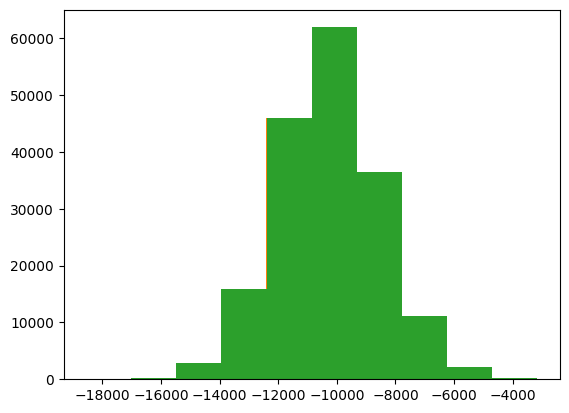

In [ ]:
import matplotlib.pyplot as plt
_ = plt.hist(E_reactant)
_ = plt.hist(E_product)
_ = plt.hist(E_transition_state)

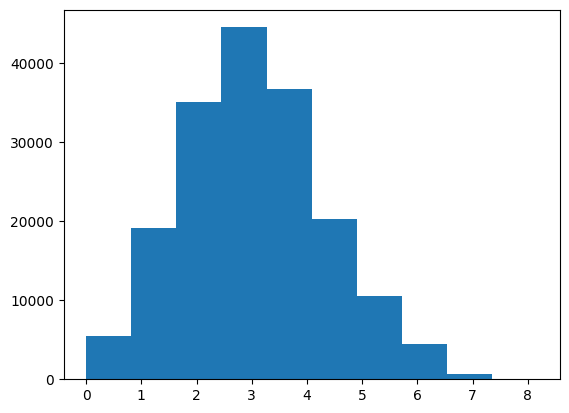

In [ ]:

_ = plt.hist(np.array(E_transition_state) - np.array(E_reactant))